## Loading Dataset 

In [1]:
# Server Paths 
# ..data/avo727/PromptTuning/CWNdata/Sean_PT2_encoded_dataset
maindir = "/mnt/md0/data/avo727/PromptTuning"
datadir = f"{maindir}/CWN_data"
preddir = f"{maindir}/model_predictions"
datasetdir= f"{maindir}/CWNdata/PT2_allchoice_encoded_dataset"

In [2]:
import pickle
from datasets import Dataset, load_metric
import datasets
from transformers import AutoModelForMultipleChoice, BertTokenizerFast
import random
import torch
import numpy as np
encoded_dataset = datasets.load_from_disk(datasetdir)

In [3]:
len(encoded_dataset['test']['numchoices'])

123

## Data Collator 

In [4]:
base_model = 'bert-base-chinese'
tokenizer = BertTokenizerFast.from_pretrained(base_model)

In [5]:
from dataclasses import dataclass
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    allchoice version: 全數攤平送往model內部處理（不經unflatten，確保傳輸numchoices）
    """
    tokenizer = tokenizer
    padding, trunc = True, True
    max_length =  None
    pad_to_multiple_of = None
    
    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        pin_label = True if "label" in features[0].keys() else False
        accepted_keys = ["input_ids", "attention_mask", "label", 
                         "token_type_ids", 'class_selector', 'numchoices']
        batch_size = len(features)
        labels = [feature.pop(label_name) for feature in features]
        numchoices = [feature.pop('numchoices') for feature in features]
        seq_classes = [feature.pop('class_selector') for feature in features]
        
        flattened_features = [[{k: v[i] for k, v in feature.items() if k in accepted_keys} 
                               for i in range(nc)] for feature, nc in zip(features, numchoices)]
        flattened_features = sum(flattened_features, [])
        batch = self.tokenizer.pad(
            flattened_features,
            padding= "longest",
            max_length= self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        # processing labels: 
        proclabels = []
        for l, nc in zip(labels, numchoices):
            label = [0]*nc
            label[l] = 1
            proclabels.extend(label)
        batch = {k: v for k, v in batch.items() if k in accepted_keys}
        assert len(proclabels) ==  len(batch['input_ids'])
        # print(len(batch['input_ids'])) # print(sum([len(x) for x in seq_classes])) # should match 
        # flattening list of lists
        batch["class_selector"] = torch.tensor(sum(seq_classes, [])) 
        batch["labels"] = torch.tensor(proclabels, dtype=torch.int64)
        batch["numchoices"] = torch.tensor(numchoices, dtype=torch.int64)
        # all flattened into instances (instead of problems)
        return batch

## Compute Metrics

In [6]:
# ( predictions: typing.Union[numpy.ndarray, typing.Tuple[numpy.ndarray]]
# label_ids: typing.Union[numpy.ndarray, typing.Tuple[numpy.ndarray]] )
class ComputeMetrics:
    from datasets import Dataset, load_metric
    datasetdir= f"{maindir}/CWNdata/PT2_allchoice_encoded_dataset"
    encoded_dataset = datasets.load_from_disk(datasetdir)
    numchoices = encoded_dataset['test']['numchoices']
    def __call__(self, logits, labels):
        # eval_batch_size = len(encoded_dataset['test'])
        # 題號，labels(還原)，預測label 
        from collections import defaultdict 
        mapping, label_mapping, prediction_mapping = defaultdict(list),defaultdict(list), defaultdict(list)
        curstart = 0
        accu = defaultdict(int)
        accdict = {}
        for exid, nc in enumerate(self.numchoices):
            label_id = labels[exid]
            pred_id = np.argmax([logits[i] for i in range(curstart, curstart+nc)])
            mapping[nc].append(exid) 
            label_mapping[nc].append(label_id)
            prediction_mapping[nc].append(pred_id)
            if label_id == pred_id: 
                accu[nc] += 1
            # update 
            curstart = curstart+nc
        cnt_numchoices = len(mapping) # 2
        # print(f'* There are {cnt_numchoices} numchoices in the dataset.')
        # return {'accuracy': (preds == label_ids).astype(np.float32).mean().item()}
        for nc, nctotal in mapping.items():
            accurates = accu[nc]
            accdict[nc] = (accurates/len(nctotal))
        accurates = sum(accu.values())
        return accurates/len(self.numchoices), accdict

In [7]:
import numpy as np 
labels = [0,0,1]
np.argmax([labels[i] for i in range(0, 3)])

2

In [8]:
logits = torch.tensor([0.5,0.2,0.3, 0.4,0.1, 0.5])
logits

tensor([0.5000, 0.2000, 0.3000, 0.4000, 0.1000, 0.5000])

In [9]:
pred_id = np.argmax([logits[i] for i in range(0, 3)])
pred_id 

0

In [10]:
x = {'2':1, '3':3}
sum(x.values())

4

In [11]:
print(f'{5:.3f}')

5.000


## 🍀 Manual Training Loop 

In [12]:
# class SchedulerType(ExplicitEnum):
#     LINEAR = "linear"
#     COSINE = "cosine"
#     COSINE_WITH_RESTARTS = "cosine_with_restarts"
#     POLYNOMIAL = "polynomial"
#     CONSTANT = "constant"
#     CONSTANT_WITH_WARMUP = "constant_with_warmup"

In [13]:
### hyperparams
base_model = 'bert-base-chinese'
batchsize = 12
prompt_len = n_tokens = 12
lr = 5e-4 # 5e-4
scheduler_type = "linear"
wd = 0.005 # best 0.005
warmup_ratio = 0.1
max_grad_norm = 1 # pytorch trainer default 
myseed = 1126   # best 1126
epochs = 20     # best 20
# accumulation_steps = 1 # pytorch trainer default 
###### task-specific stats ##### 
nclass = 19
TESTSIZE = 0.2

In [14]:
import torch
import torch.nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from transformers import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import MultipleChoiceModelOutput

In [15]:
%reload_ext autoreload
%autoreload 2

In [16]:
from PromptTuningBERT_allchoice_v2 import BertPromptForMultipleChoice
config = {
    'n_tokens': prompt_len ,
    'n_class': nclass,
    'train_bert': False,
    'to_debug': False,
    'device': 'cuda'
}
model = BertPromptForMultipleChoice.from_pretrained(base_model, config)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertPromptForMultipleChoice: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertPromptForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertPromptForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertPromptForMultipleChoice were not initialized from the model checkpoint at bert-ba

** total param is 175873
** train bert? False


In [17]:
'''seeding'''
import torch.optim as optim
from transformers import set_seed, get_scheduler
def set_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  
set_seeds(myseed)
set_seed(myseed)

In [18]:
model.to('cuda')

BertPromptForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [19]:
'''grad accum steps'''
# https://gist.github.com/thomwolf/ac7a7da6b1888c2eeac8ac8b9b05d3d3
'''trainer'''
# https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L1453
'''scheduler with warm up'''
# https://github.com/huggingface/transformers/blob/198c335d219a5eb4d3f124fdd1ce1a9cd9f78a9b/src/transformers/optimization.py#L75

'scheduler with warm up'

In [19]:
'''creating model directory'''
from datetime import datetime
import os
import wandb 
now = datetime.now()
timeprefix = now.strftime("%m%d-%H%M")
runname = f'{timeprefix}_RPBert_allc'

model_dir = f'{maindir}/runs_v2/{runname}'
print('*\tName of the run:', runname)
os.makedirs(model_dir, exist_ok = True)

wandb.init(project='prompt_tuning_rp_v3', name = runname, 
           entity='nana2929', group="no trainer")
wandb.config.update({
    'learning_rate':lr,
    'batch_size':batchsize,
    'weight_decay':wd,
    'seed':myseed,
    'n_tokens':n_tokens, 
    'epochs':epochs, 
    'scheduler': scheduler_type,  
})
# WANDB_NOTEBOOK_NAME

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


*	Name of the run: 0328-1616_RPBert_allc


wandb: Currently logged in as: nana2929 (use `wandb login --relogin` to force relogin)


In [22]:
#print(scheduler)

In [20]:
import torch
from torch import nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler)
from PromptTuningBERT_allchoice_v2 import BertPromptForMultipleChoice
from tqdm import tqdm 

train_loader = DataLoader(encoded_dataset['train'], 
                    shuffle=False, 
                    collate_fn=DataCollatorForMultipleChoice(), 
                    batch_size=batchsize)
num_warmup_steps = warmup_ratio * epochs * len(train_loader)
num_tr_steps = epochs * len(train_loader)
'''weight decay (in optimizer)'''
optimizer = optim.AdamW(model.parameters(), 
                        lr=lr, 
                        weight_decay = wd, # 有兩種weight decay方法
                        eps = 1e-08) # 1e-08, training args default 
'''scheduler/warmup'''
# https://github.com/huggingface/transformers/blob/main/src/transformers/optimization.py#L233
# scheduler = get_scheduler(scheduler_type, optimizer, 
#                           num_warmup_steps = num_warmup_steps, 
#                           num_training_steps = num_tr_steps)
eval_loader = DataLoader(encoded_dataset['test'], 
                    shuffle=False, 
                    collate_fn=DataCollatorForMultipleChoice(), 
                    batch_size=batchsize)
n_train_batch, n_eval_batch = len(train_loader), len(eval_loader)
print('train batch number:', n_train_batch, '\neval batch number:', n_eval_batch)

train batch number: 41 
eval batch number: 11


In [21]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler)

loss_vec, eloss_vec = [], []
best_eval_acc = 0 
for epoch in range(epochs):
    '''training'''
    model.train()
    tr_loss, ev_loss = 0,0 
    for i, batch in enumerate(train_loader):  
        batch = {k: batch[k].to('cuda') for k in batch}
        out = model(**batch)
        loss = out.loss
        tr_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # scheduler.step()
    loss_vec.append((tr_loss/n_train_batch))
    '''evaluating'''
    print(f'epoch {epoch+1}')
    model.eval()
    all_labels, all_logits = [], []
    for i, batch in enumerate(eval_loader):
        with torch.no_grad():
            batch = {k: batch[k].to('cuda') for k in batch}
            out = model(**batch)
            loss = out.loss
            ev_loss += loss.item()
            logits = out.logits
            labels = batch['labels'].cpu().detach().numpy()
            logits = logits.cpu().detach().numpy()
            all_labels.append(labels)
            all_logits.append(logits)
    eloss_vec.append(ev_loss/n_eval_batch)      
    # concatenating the logits
    '''Computing metrics and logging'''
    all_labels = np.concatenate(all_labels, axis = None)
    all_logits = np.concatenate(all_logits, axis = None)
    eval_acc, eval_acc_dict = ComputeMetrics()(all_logits, all_labels)
    print(f'*\ttrain loss: {(tr_loss/n_train_batch):.4f}' )
    print(f'*\teval loss: {(ev_loss/n_eval_batch):.4f},  \teval acc: {eval_acc:.4f}')
    if best_eval_acc < eval_acc:
        print(f'* \tSaving model at eval accuracy: {eval_acc}.')
        # model.save_pretrained(model_dir)
        best_eval_acc = eval_acc
#     wandb.log({
#             "train loss": tr_loss/n_train_batch,
#             "eval loss": ev_loss/n_eval_batch,
#             "eval acc": eval_acc,
#         })
    for k, v in eval_acc_dict.items():
        print(f'*\tacc|numchoice = {k}: {v:.3f}') 

epoch 1
*	train loss: 0.7000
*	eval loss: 0.6898,  	eval acc: 0.4715
* 	Saving model at eval accuracy: 0.4715447154471545.
*	acc|numchoice = 2: 0.460
*	acc|numchoice = 3: 0.600
epoch 2
*	train loss: 0.6764
*	eval loss: 0.6927,  	eval acc: 0.4878
* 	Saving model at eval accuracy: 0.4878048780487805.
*	acc|numchoice = 2: 0.504
*	acc|numchoice = 3: 0.300
epoch 3
*	train loss: 0.6778
*	eval loss: 0.6862,  	eval acc: 0.4878
*	acc|numchoice = 2: 0.478
*	acc|numchoice = 3: 0.600
epoch 4
*	train loss: 0.6701
*	eval loss: 0.6865,  	eval acc: 0.5366
* 	Saving model at eval accuracy: 0.5365853658536586.
*	acc|numchoice = 2: 0.513
*	acc|numchoice = 3: 0.800
epoch 5
*	train loss: 0.6664
*	eval loss: 0.6922,  	eval acc: 0.5447
* 	Saving model at eval accuracy: 0.5447154471544715.
*	acc|numchoice = 2: 0.522
*	acc|numchoice = 3: 0.800
epoch 6
*	train loss: 0.6464
*	eval loss: 0.6960,  	eval acc: 0.5285
*	acc|numchoice = 2: 0.513
*	acc|numchoice = 3: 0.700
epoch 7
*	train loss: 0.6317
*	eval loss: 0.70

In [ ]:
# 1. model.train()和model.eval()竟然影響ㄌupdates <-沒設的時候一切正常，有設就沒法backward()??
#                                                 感覺下降幅度變慢（15 epochs內只能0.71 -> 0.33，降0.2~0.3）
#                                                 而且幅度抖動比較不穩定
# 2. 加gradient accumulation steps（甚至只開1也有差），也是 15 epochs內只能0.71 -> 0.417
# 3. labels=torch.tensor(labels, dtype=torch.float32).to(self._device)
#    vs. sourceTensor.clone().detach()
# 4. 加入gradient clipping (第二層for 迴圈內)直接爆掉，整個loss完全不會動
# 5. 加scheduler下降幅度超級慢，15 epochs內只能0.75 -> 0.67
# 最好的狀態大概是eval acc = 0.53，不加scheduler和grad-clipping

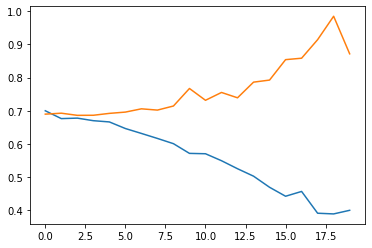

In [22]:
from matplotlib import pyplot as plt
plt.plot(loss_vec)
plt.plot(eloss_vec)

In [ ]:
# toy example 
model = BertPromptForMultipleChoice.from_pretrained(base_model, config)
model.to('cuda')
loss_vec = []
for i in range(20):# epochs = 20 
    for batch in train_loader:  
        batch = {k: batch[k].to('cuda') for k in batch}
        optimizer.zero_grad()
        out = model(**batch)
        loss = out.loss
        loss.backward()
        optimizer.step()
        loss_vec.append(loss.item())
    print(loss_vec[-1])

In [ ]:
from matplotlib import pyplot as plt
plt.plot(loss_vec)

In [ ]:
'''gradient-clipping'''
# if hasattr(optimizer, "clip_grad_norm"):
#     # Some optimizers (like the sharded optimizer) have a specific way to do gradient clipping
#     optimizer.clip_grad_norm(max_grad_norm)
# elif hasattr(model, "clip_grad_norm_"):
#     # Some models (like FullyShardedDDP) have a specific way to do gradient clipping
#     model.clip_grad_norm_(max_grad_norm)
# else: # fall back to normal torch utils
#     nn.utils.clip_grad_norm_(
#         model.parameters(),
#         max_grad_norm,
#     )

## To-add features